<a href="https://colab.research.google.com/github/SegFL/Python/blob/main/wine_review_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub


In [7]:


df=pd.read_csv("wine-reviews.csv",usecols=['country','description','points','price'])

In [8]:
df.head

<bound method NDFrame.head of          country                                        description  points  \
0          Italy  Aromas include tropical fruit, broom, brimston...      87   
1       Portugal  This is ripe and fruity, a wine that is smooth...      87   
2             US  Tart and snappy, the flavors of lime flesh and...      87   
3             US  Pineapple rind, lemon pith and orange blossom ...      87   
4             US  Much like the regular bottling from 2012, this...      87   
...          ...                                                ...     ...   
129966   Germany  Notes of honeysuckle and cantaloupe sweeten th...      90   
129967        US  Citation is given as much as a decade of bottl...      90   
129968    France  Well-drained gravel soil gives this wine its c...      90   
129969    France  A dry style of Pinot Gris, this is crisp with ...      90   
129970    France  Big, rich and off-dry, this is powered by inte...      90   

        price  
0         NaN  
1        15.0  
2        14.0  
3        13.0  
4        65.0  
...       ...  
129966   28.0  
129967   75.0  
129968   30.0  
129969   32.0  
129970   21.0  

[129971 rows x 4 columns]>

In [9]:
df=df.dropna(subset=['description','points'])

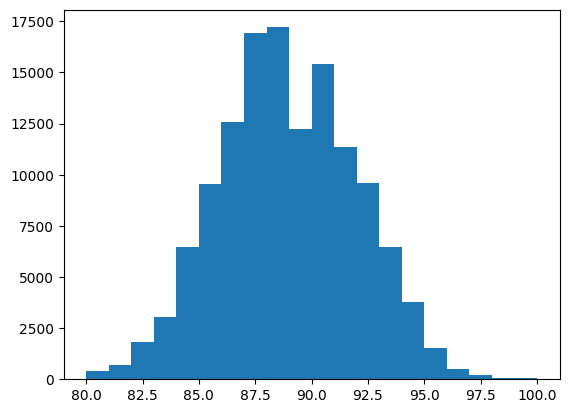

In [10]:
plt.hist(df.points,bins=20)
plt.show()

In [11]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","label"]]

In [12]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [13]:
def df_to_dataset(dataframe,shuffle=True,batch_size=1024):
  df=dataframe.copy()
  labels=df.pop('label')
  df=df["description"]
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [14]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

Embedding+Model


In [15]:
embedding="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

In [16]:
model=tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.evaluate(train_data)

102/102 [==============================] - 2s 14ms/step - loss: 0.6744 - accuracy: 0.6226


[0.6744093894958496, 0.6225859522819519]

In [89]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.7053 - accuracy: 0.4343


[0.7052538990974426, 0.4343309998512268]

In [19]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 141s 1s/step - loss: 0.6023 - accuracy: 0.6413 - val_loss: 0.5055 - val_accuracy: 0.7668
Epoch 2/5
102/102 [==============================] - 139s 1s/step - loss: 0.4788 - accuracy: 0.7992 - val_loss: 0.4454 - val_accuracy: 0.8107
Epoch 3/5
102/102 [==============================] - 138s 1s/step - loss: 0.4248 - accuracy: 0.8279 - val_loss: 0.4298 - val_accuracy: 0.8159
Epoch 4/5
102/102 [==============================] - 139s 1s/step - loss: 0.3914 - accuracy: 0.8436 - val_loss: 0.4245 - val_accuracy: 0.8133
Epoch 5/5
102/102 [==============================] - 139s 1s/step - loss: 0.3693 - accuracy: 0.8546 - val_loss: 0.4326 - val_accuracy: 0.8192
